In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

os.chdir("/content/drive/MyDrive/Credit Card Fraud Analysis")
print(os.getcwd())

/content/drive/MyDrive/Credit Card Fraud Analysis


In [3]:
!pip install -r requirements.txt

# Data reading and setting

In [4]:
import src.visualization as vis
import warnings

warnings.resetwarnings()
warnings.simplefilter('ignore')

In [5]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("credit_card_fraud_analysis") \
    .getOrCreate()

In [6]:
data = spark.read.csv("inputs/processed_data", header=True, inferSchema=True)
data.show()

+--------------------+-------------+------+------+----------------+-----+-------+---------+--------+--------------------+------------------+------------------+--------+-------+---+-----------+----------+-----------------+------------------+-----------------+-----------+
|            merchant|     category|   amt|gender|            city|state|    lat|     long|city_pop|                 job|         merch_lat|        merch_long|is_fraud|portion|age|trans_month|trans_hour|trans_day_of_week|trans_day_of_month|trans_day_of_year|distance_km|
+--------------------+-------------+------+------+----------------+-----+-------+---------+--------+--------------------+------------------+------------------+--------+-------+---+-----------+----------+-----------------+------------------+-----------------+-----------+
|fraud_Raynor, Rei...|gas_transport| 61.15|     M|   West Hartford|   VT|43.7185| -72.4439|     140|Development worke...|         44.208355|        -72.133812|       0|  train| 35|       

In [ ]:
data.printSchema()

root
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- portion: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- trans_month: integer (nullable = true)
 |-- trans_hour: integer (nullable = true)
 |-- trans_day_of_week: integer (nullable = true)
 |-- trans_day_of_month: integer (nullable = true)
 |-- trans_day_of_year: integer (nullable = true)
 |-- distance_km: double (nullable = true)



In [28]:
min_sample = data.groupby('is_fraud').count().orderBy('count').limit(1).collect()[0][1]
min_sample

9651

# Numerical columns

In [7]:
from pyspark.sql.types import NumericType

numerical_columns = [col for col, dtype in data.dtypes if isinstance(data.schema[col].dataType, NumericType) and col != 'is_fraud']
numerical_columns

['amt',
 'lat',
 'long',
 'city_pop',
 'merch_lat',
 'merch_long',
 'age',
 'trans_month',
 'trans_hour',
 'trans_day_of_week',
 'trans_day_of_month',
 'trans_day_of_year',
 'distance_km']

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

vectorAssembler = VectorAssembler(inputCols=numerical_columns, outputCol="features")
data_vector = vectorAssembler.transform(data)

correlation_matrix = Correlation.corr(data_vector, "features").head()[0]

<Axes: >

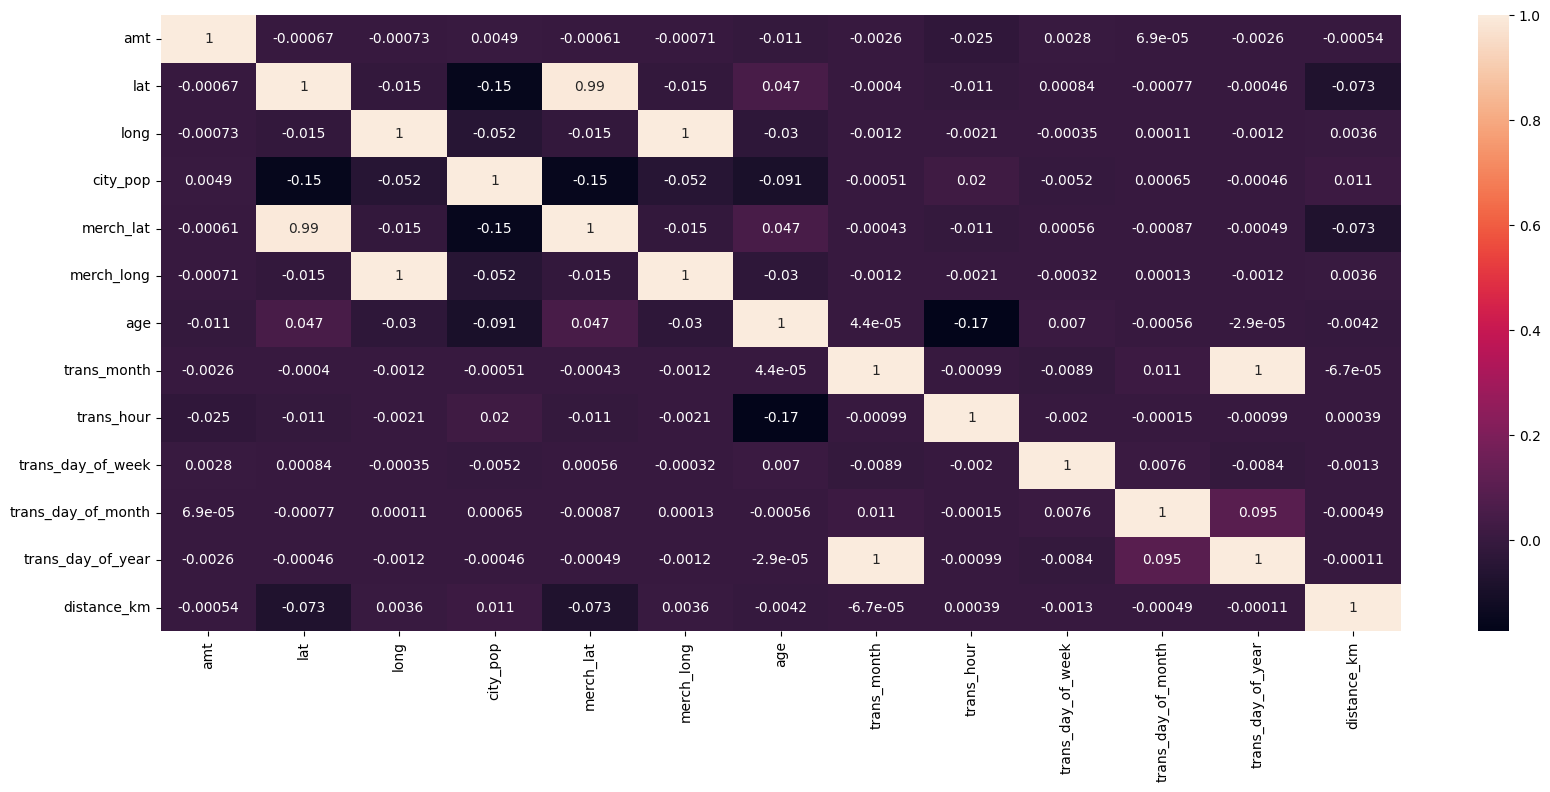

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix.toArray(), annot=True, xticklabels=numerical_columns, yticklabels=numerical_columns)

## Coordinates features

In [ ]:
coordinates = data.select('merch_lat', 'lat', 'long', 'merch_long', 'is_fraud').toPandas()
coordinates

merch_lat      lat      long  merch_long  is_fraud
0        44.208355  43.7185  -72.4439  -72.133812         0
1        27.064663  26.5290  -82.0916  -81.798000         0
2        32.063623  31.1569  -94.3871  -95.240577         0
3        33.941192  33.6773 -118.0051 -118.127544         0
4        42.216841  43.0330  -77.1575  -76.889115         0
...            ...      ...       ...         ...       ...
1852389  39.946837  40.4931  -91.8912  -91.333331         0
1852390  29.661049  29.0393  -95.4401  -96.186633         0
1852391  46.658340  46.1966 -118.9017 -119.715054         0
1852392  44.470525  44.6255 -116.4493 -117.080888         0
1852393  36.210097  35.6665  -97.4798  -97.036372         0

[1852394 rows x 5 columns]

In [ ]:
coordinates_sample = coordinates.groupby('is_fraud').apply(lambda x: x.sample(min_sample)).reset_index(drop=True)
coordinates_sample

<ipython-input-47-cb6f09c7c744>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  coordinates_sample = coordinates.groupby('is_fraud').apply(lambda x: x.sample(9651)).reset_index(drop=True)


merch_lat      lat      long  merch_long  is_fraud
0      32.770263  32.8463  -96.6972  -97.019301         0
1      37.406104  37.9931 -100.9893 -101.858723         0
2      40.915562  41.5686  -83.3632  -83.850348         0
3      32.436653  31.6453  -90.1801  -89.914091         0
4      32.441426  31.8287  -99.4270  -99.286806         0
...          ...      ...       ...         ...       ...
19297  39.321378  39.2136  -95.4404  -94.708458         1
19298  35.915237  36.4539  -94.1180  -93.463160         1
19299  42.311352  42.3200  -78.0943  -77.378428         1
19300  38.733231  38.9763  -87.3667  -87.618866         1
19301  32.606722  31.8287  -99.4270 -100.121892         1

[19302 rows x 5 columns]

In [ ]:
coordinates_sample['is_fraud'].value_counts()

is_fraud
0    9651
1    9651
Name: count, dtype: int64

In [ ]:
import pygwalker as pyg
gwalker = pyg.walk(coordinates_sample)

Box(children=(HTML(value='\n<div id="ifr-pyg-000628fffd703a56ulPhEZv23KjpsRLT" style="height: auto">\n    <hea…

In [ ]:
gwalker = pyg.walk(coordinates)

Output hidden; open in https://colab.research.google.com to view.

`There is a high correlation between merch_lat and lat, but no significant pattern in the coordinates data.`

In [ ]:
del coordinates_sample, gwalker, coordinates

In [8]:
data = data.drop('merch_lat', 'lat', 'long', 'merch_long')
data.show()

+--------------------+-------------+------+------+----------------+-----+--------+--------------------+--------+-------+---+-----------+----------+-----------------+------------------+-----------------+-----------+
|            merchant|     category|   amt|gender|            city|state|city_pop|                 job|is_fraud|portion|age|trans_month|trans_hour|trans_day_of_week|trans_day_of_month|trans_day_of_year|distance_km|
+--------------------+-------------+------+------+----------------+-----+--------+--------------------+--------+-------+---+-----------+----------+-----------------+------------------+-----------------+-----------+
|fraud_Raynor, Rei...|gas_transport| 61.15|     M|   West Hartford|   VT|     140|Development worke...|       0|  train| 35|          8|        10|                1|                 4|              216|   59.85688|
|fraud_Vandervort-...|  grocery_pos| 55.25|     M|Saint James City|   FL|    3776|Sport and exercis...|       0|  train| 48|          8|    

In [9]:
removed_cols = ['merch_lat', 'lat', 'long', 'merch_long']
numerical_columns = [col for col in numerical_columns if col not in removed_cols]

In [10]:
num_data = data.select(numerical_columns + ['is_fraud']).toPandas().groupby('is_fraud').apply(lambda x: x.sample(min_sample)).reset_index(drop=True)
num_data

amt  city_pop  age  trans_month  trans_hour  trans_day_of_week  \
0        53.37     93193   29           10           8                  2   
1        56.99      1909   70           12           7                  5   
2        13.58     11256   52            1          22                  2   
3        25.88     86954   32           12          12                  3   
4        52.92      1446   46            4          10                  2   
...        ...       ...  ...          ...         ...                ...   
19297   993.47      9165   61            9          23                  7   
19298   816.12      5657   37            6          23                  1   
19299   550.36   2906700   41            4           5                  4   
19300   789.46      1414   66            5          23                  7   
19301  1179.99      7565   72            6          22                  2   

       trans_day_of_month  trans_day_of_year  distance_km  is_fraud  
0                       7                280    97.860800         0  
1                      10                345    46.277504         0  
2                      28                 28    97.215110         0  
3                      31                365   119.435940         0  
4                       6                 97   109.742370         0  
...                   ...                ...          ...       ...  
19297                  21                264    52.380610         1  
19298                   7                159   108.508160         1  
19299                   8                 99    61.499954         1  
19300                   9                130    90.144230         1  
19301                   3                154   110.876380         1  

[19302 rows x 10 columns]

Plotting KDE plots grouped by is_fraud: 100%|██████████| 9/9 [00:01<00:00,  4.88it/s]


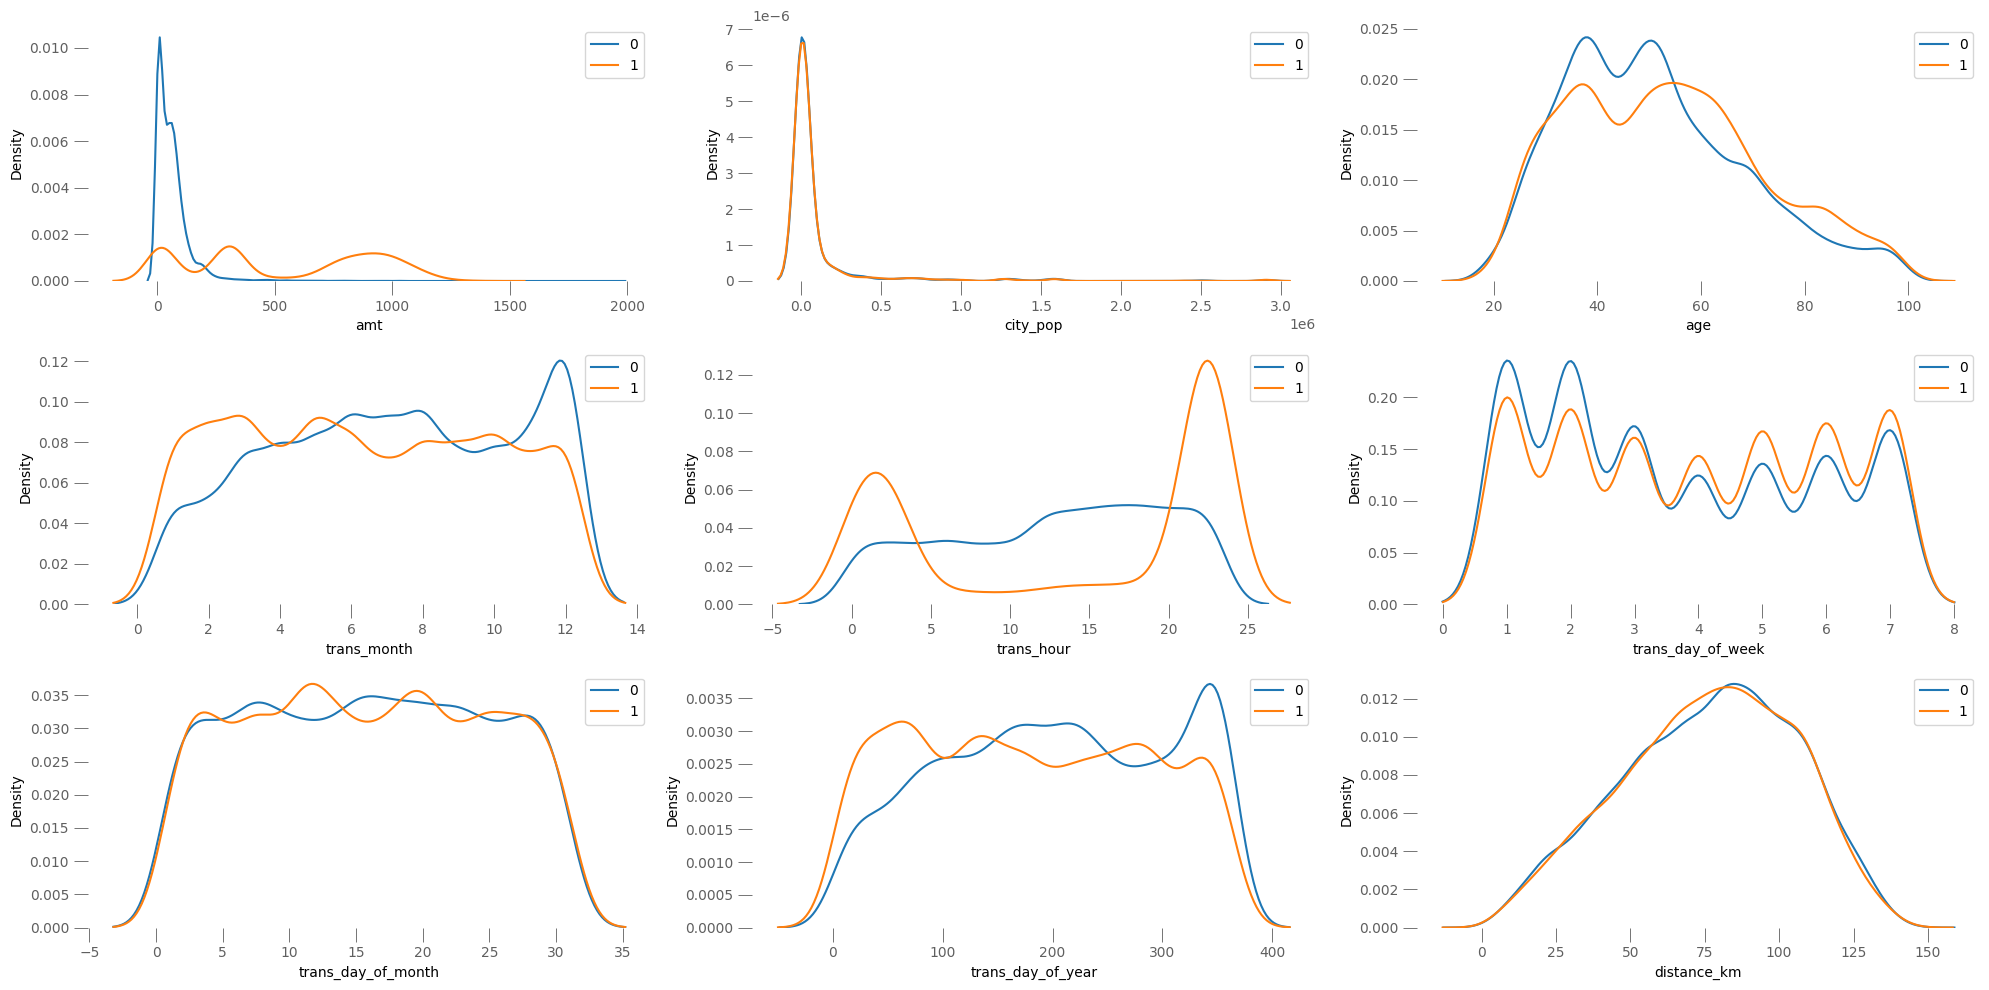

In [11]:
vis.kdeplots(num_data, shape = (3, 3), y='is_fraud')

In [12]:
#Generating new features
import numpy as np

for col in numerical_columns:
  num_data[f'ln_{col}'] = np.log(num_data[col] + 1e-6)
  num_data[f'sqrt_{col}'] = np.sqrt(num_data[col])
num_data.head()

amt  city_pop  age  trans_month  trans_hour  trans_day_of_week  \
0  53.37     93193   29           10           8                  2   
1  56.99      1909   70           12           7                  5   
2  13.58     11256   52            1          22                  2   
3  25.88     86954   32           12          12                  3   
4  52.92      1446   46            4          10                  2   

   trans_day_of_month  trans_day_of_year  distance_km  is_fraud  ...  \
0                   7                280    97.860800         0  ...   
1                  10                345    46.277504         0  ...   
2                  28                 28    97.215110         0  ...   
3                  31                365   119.435940         0  ...   
4                   6                 97   109.742370         0  ...   

   ln_trans_hour  sqrt_trans_hour  ln_trans_day_of_week  \
0       2.079442         2.828427              0.693148   
1       1.945910         2.645751              1.609438   
2       3.091042         4.690416              0.693148   
3       2.484907         3.464102              1.098613   
4       2.302585         3.162278              0.693148   

   sqrt_trans_day_of_week  ln_trans_day_of_month  sqrt_trans_day_of_month  \
0                1.414214               1.945910                 2.645751   
1                2.236068               2.302585                 3.162278   
2                1.414214               3.332205                 5.291503   
3                1.732051               3.433987                 5.567764   
4                1.414214               1.791760                 2.449490   

   ln_trans_day_of_year  sqrt_trans_day_of_year  ln_distance_km  \
0              5.634790               16.733201        4.583546   
1              5.843544               18.574176        3.834656   
2              3.332205                5.291503        4.576926   
3              5.899897               19.104973        4.782780   
4              4.574711                9.848858        4.698136   

   sqrt_distance_km  
0          9.892462  
1          6.802757  
2          9.859772  
3         10.928675  
4         10.475799  

[5 rows x 28 columns]

Plotting KDE plots grouped by is_fraud: 100%|██████████| 18/18 [00:03<00:00,  5.00it/s]


<Figure size 640x480 with 0 Axes>

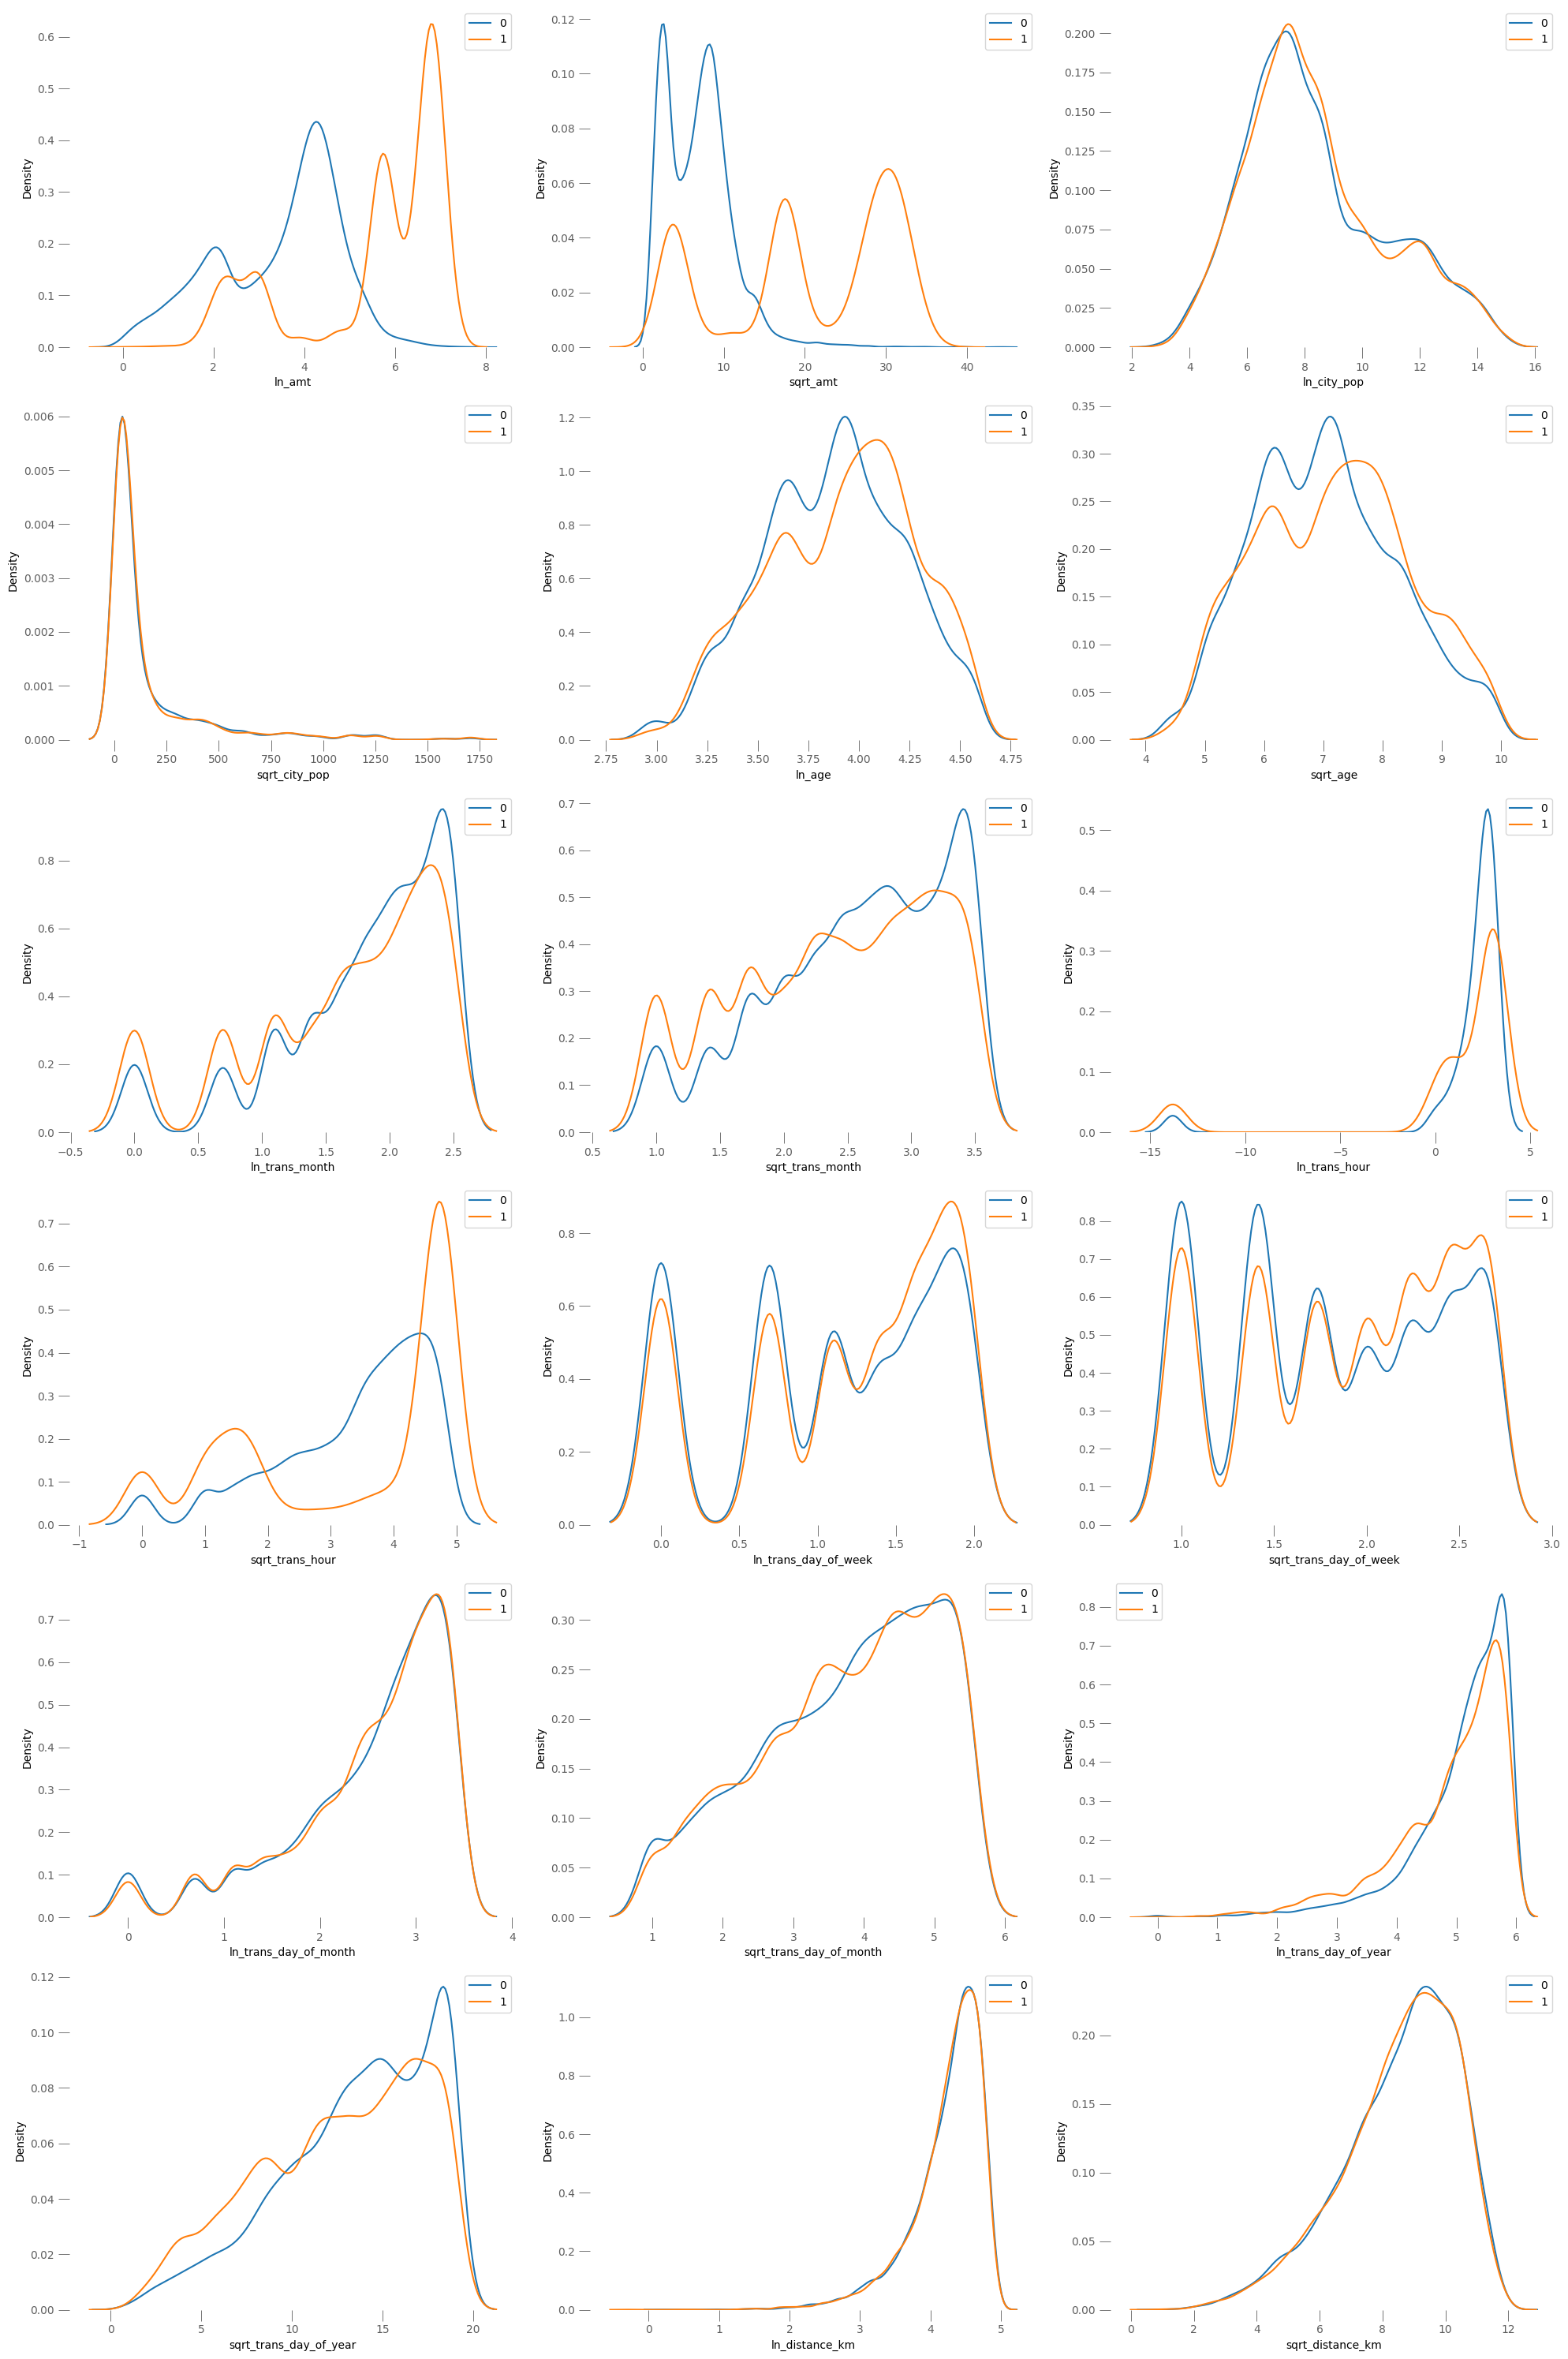

In [13]:
columns_to_plot = [
    col for col in num_data.columns
    if ('ln' in col or 'sqrt' in col) or col == 'is_fraud'
]
vis.kdeplots(num_data[columns_to_plot], y='is_fraud', shape = (6, 3), figsize=(20, 30))

# Categorial Columns

In [30]:
categorical_columns = [col for col, dtype in data.dtypes if dtype == 'string' and col != 'portion']
categorical_columns

['merchant', 'category', 'gender', 'city', 'state', 'job']

In [31]:
BOLD = "\033[1m"
RESET = "\033[0m"

for col in categorical_columns:
    print(f'{BOLD}{col}{RESET}: ')

    distinct_count = data.select(col).distinct().count()
    print(f'\tNumber of distinct values in {col}: {distinct_count}')

    top_10_categories = data.groupBy(col).count() \
                            .orderBy("count", ascending=False) \
                            .limit(10)

    print(f'\tTop 10 most frequent categories in {col}:')
    for row in top_10_categories.collect():
        print(f'\t\t{row[col]}: {row["count"]}')


    mode_row = top_10_categories.first()
    if mode_row:
        mode_value = mode_row[col]
        mode_count = mode_row["count"]
        print(f'\tMode of {col}: {mode_value} with count {mode_count}')
    print()


merchant: 
	Number of distinct values in merchant: 693
	Top 10 most frequent categories in merchant:
		fraud_Kilback LLC: 6262
		fraud_Cormier LLC: 5246
		fraud_Schumm PLC: 5195
		fraud_Kuhn LLC: 5031
		fraud_Boyer PLC: 4999
		fraud_Dickinson Ltd: 4953
		fraud_Emard Inc: 3867
		fraud_Cummerata-Jones: 3860
		fraud_Corwin-Collins: 3853
		fraud_Rodriguez Group: 3843
	Mode of merchant: fraud_Kilback LLC with count 6262

category: 
	Number of distinct values in category: 14
	Top 10 most frequent categories in category:
		gas_transport: 188029
		grocery_pos: 176191
		home: 175460
		shopping_pos: 166463
		kids_pets: 161727
		shopping_net: 139322
		entertainment: 134118
		food_dining: 130729
		personal_care: 130085
		health_fitness: 122553
	Mode of category: gas_transport with count 188029

gender: 
	Number of distinct values in gender: 2
	Top 10 most frequent categories in gender:
		F: 1014749
		M: 837645
	Mode of gender: F with count 1014749

city: 
	Number of distinct values in city: 906
	T

In [32]:
cat_data = data.select(categorical_columns + ['is_fraud'])
cat_data.show()

+--------------------+-------------+------+----------------+-----+--------------------+--------+
|            merchant|     category|gender|            city|state|                 job|is_fraud|
+--------------------+-------------+------+----------------+-----+--------------------+--------+
|fraud_Raynor, Rei...|gas_transport|     M|   West Hartford|   VT|Development worke...|       0|
|fraud_Vandervort-...|  grocery_pos|     M|Saint James City|   FL|Sport and exercis...|       0|
| fraud_Stracke-Lemke|  grocery_pos|     M|         Zavalla|   TX| Designer, jewellery|       0|
|fraud_Schamberger...|  grocery_pos|     F|Huntington Beach|   CA|Therapist, hortic...|       0|
|fraud_Schamberger...|  grocery_pos|     F|     Port Gibson|   NY|Database administ...|       0|
|fraud_Schamberger...|  grocery_pos|     F|    Santa Monica|   CA|Civil engineer, c...|       0|
|   fraud_Kilback LLC|  grocery_pos|     M|         Comfrey|   MN|Health and safety...|       0|
|fraud_Heller-Langosh|gas_tran

In [39]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.stat import ChiSquareTest
from pyspark.sql.functions import col


cat_data = StringIndexer(inputCols=categorical_columns, outputCols=[f"indexed_{col}" for col in categorical_columns]).fit(cat_data).transform(cat_data)
cat_data.show()

+--------------------+-------------+------+----------------+-----+--------------------+--------+----------------+----------------+--------------+------------+-------------+-----------+
|            merchant|     category|gender|            city|state|                 job|is_fraud|indexed_merchant|indexed_category|indexed_gender|indexed_city|indexed_state|indexed_job|
+--------------------+-------------+------+----------------+-----+--------------------+--------+----------------+----------------+--------------+------------+-------------+-----------+
|fraud_Raynor, Rei...|gas_transport|     M|   West Hartford|   VT|Development worke...|       0|            32.0|             0.0|           1.0|       217.0|         38.0|       98.0|
|fraud_Vandervort-...|  grocery_pos|     M|Saint James City|   FL|Sport and exercis...|       0|           106.0|             1.0|           1.0|       296.0|          7.0|      241.0|
| fraud_Stracke-Lemke|  grocery_pos|     M|         Zavalla|   TX| Designer

In [40]:
assembled_features = VectorAssembler(inputCols=[f"indexed_{col}" for col in categorical_columns], outputCol="features")
cat_data = assembled_features.transform(cat_data)
cat_data.show()

+--------------------+-------------+------+----------------+-----+--------------------+--------+----------------+----------------+--------------+------------+-------------+-----------+--------------------+
|            merchant|     category|gender|            city|state|                 job|is_fraud|indexed_merchant|indexed_category|indexed_gender|indexed_city|indexed_state|indexed_job|            features|
+--------------------+-------------+------+----------------+-----+--------------------+--------+----------------+----------------+--------------+------------+-------------+-----------+--------------------+
|fraud_Raynor, Rei...|gas_transport|     M|   West Hartford|   VT|Development worke...|       0|            32.0|             0.0|           1.0|       217.0|         38.0|       98.0|[32.0,0.0,1.0,217...|
|fraud_Vandervort-...|  grocery_pos|     M|Saint James City|   FL|Sport and exercis...|       0|           106.0|             1.0|           1.0|       296.0|          7.0|    

In [41]:
chiSqResult = ChiSquareTest.test(cat_data, 'features', 'is_fraud')

In [43]:
chiSqResult.show()

+--------------------+--------------------+--------------------+
|             pValues|    degreesOfFreedom|          statistics|
+--------------------+--------------------+--------------------+
|[0.0,0.0,1.776356...|[692, 13, 1, 905,...|[8761.09387377939...|
+--------------------+--------------------+--------------------+



In [46]:
p_values = chiSqResult.head().pValues
chi2_stats = chiSqResult.head().statistics

features = [f"indexed_{col}" for col in categorical_columns]

for feature, p_value, chi2_stat in zip(features, p_values, chi2_stats):
    print(f"Feature: {feature}, Chi-Square Stat: {chi2_stat}, p-value: {p_value}")

Feature: indexed_merchant, Chi-Square Stat: 8761.093873779399, p-value: 0.0
Feature: indexed_category, Chi-Square Stat: 8329.139945520074, p-value: 0.0
Feature: indexed_gender, Chi-Square Stat: 63.25402213730509, p-value: 1.7763568394002505e-15
Feature: indexed_city, Chi-Square Stat: 139590.93742658128, p-value: 0.0
Feature: indexed_state, Chi-Square Stat: 2022.1228324519125, p-value: 0.0
Feature: indexed_job, Chi-Square Stat: 48073.228171839364, p-value: 0.0
